<a href="https://colab.research.google.com/github/haoboooo/Temporal-Effect-of-Sentiment-Analysis/blob/main/software_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emot
!pip install -U adapter-transformers
!pip install datasets

     |████████████████████████████████| 61 kB 19 kB/s 
     |████████████████████████████████| 3.9 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 38.0 MB/s 
     |████████████████████████████████| 84 kB 1.9 MB/s 
     |████████████████████████████████| 880 kB 39.2 MB/s 
     |████████████████████████████████| 6.6 MB 55.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=8890f8ed981550c00bd77bec1b73cf92e9978c8ef46ed073ce167477316125e7
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 342 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 61.1 MB/s 
     |████████████████████████████████| 136 kB 68.4 MB/s 
     |████████████████████████████████|

In [2]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

import torch
from transformers import RobertaTokenizer
import datasets
from datasets import Dataset
from transformers import RobertaConfig, RobertaModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

In [3]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load software data

In [4]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/software/98_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/software/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/software/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/software/18.csv"

In [5]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(27028, 3)
 1.0    13613
-1.0    11120
 0.0     2295
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,-Great devotional Bible written with easy-to-u...
1,1.0,2006,I love the new king james version of the the l...
2,1.0,2005,I highly recommend this version of the bible f...
3,1.0,2005,This Bible is a great study help. The comment...
4,1.0,2005,Great Bible for study - very informative and t...


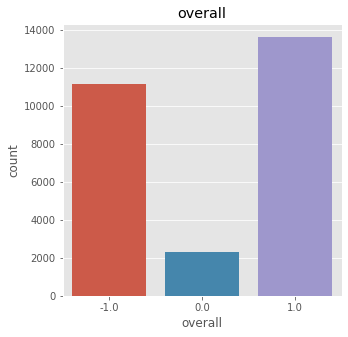

In [6]:
# load data for 1998 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(83773, 3)
 1.0    48362
-1.0    27920
 0.0     7491
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2011,"Strong backgroung, good read, quite up to date..."
1,0.0,2010,If you live on Mars and never heard of the int...
2,1.0,2010,i got this book on amazon and it ended up savi...
3,1.0,2010,I was very happy with this purchase because th...
4,1.0,2010,Recieved in a timely manner- book in great con...


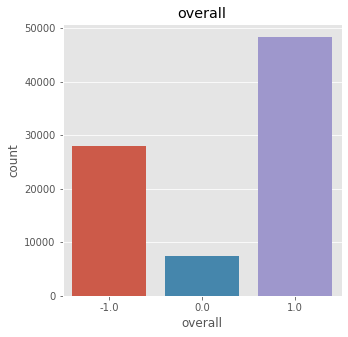

In [7]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(235021, 3)
 1.0    146179
-1.0     69066
 0.0     19776
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,The materials arrived early and were in excell...
1,1.0,2014,I am really enjoying this book with the worksh...
2,-1.0,2014,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,0.0,2014,This book was missing pages!!! Important pages...
4,1.0,2013,I have used LearnSmart and can officially say ...


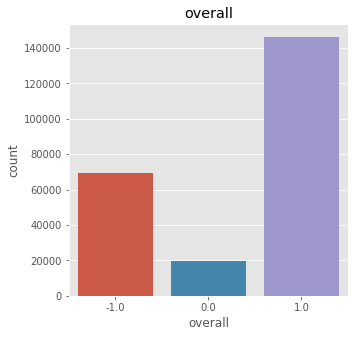

In [8]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(10435, 3)
 1.0    5925
-1.0    3732
 0.0     778
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2018,Product had false key. Fake Microsoft phone n...
1,1.0,2018,the codes worked fine. Im not really a fan of...
2,1.0,2018,This product was good i loved that i was able ...
3,1.0,2018,It is just a must have for your computer what ...
4,1.0,2018,Having access on more than one device helps.


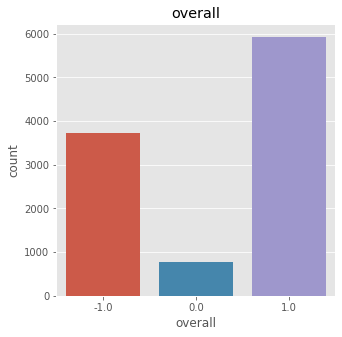

In [9]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5900 positive，3700 negative，770 neutral

80%(8056) training and 20%(2314) testing

In [10]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4480,:]
  train_neudata = neu.iloc[:616,:]
  train_negdata = neg.iloc[:2960,:]

  # split to get test for each class
  test_posdata = pos.iloc[4480:5900,:]
  test_neudata = neu.iloc[616:770,:]
  test_negdata = neg.iloc[2960:3700,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [11]:
# data for 1998 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [12]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [13]:
df1_train.head()

,overall,reviewTime,reviewText
1476,2.0,2006,"Very imprecise, poor and obsolete software. La..."
9894,2.0,2005,Typical of Microsoft - lots of places make up ...
24326,1.0,2006,I don't write reviews often but this product i...
1839,1.0,2002,Easy CD Creator 5 Platinum by Roxio is a wonde...
1182,1.0,2001,Contrary to the previous review of this produc...


## Text Preprocessing

In [14]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [15]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [16]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [17]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

## Tokenization

In [18]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=128, truncation=True, padding="max_length")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [19]:
def generate_datasetdict(dataframe1,dataframe2):
  text1 = dataframe1.cleanText.values
  text2 = dataframe2.cleanText.values

  label1 = dataframe1.overall.values.astype(np.int32)
  label2 = dataframe2.overall.values.astype(np.int32)

  train_df = pd.DataFrame({"label" : label1,"text" : text1})
  test_df = pd.DataFrame({"label" : label2,"text" : text2})

  train_dataset = Dataset.from_dict(train_df)
  test_dataset = Dataset.from_dict(test_df)
  my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

  # Encode the input data
  dataset = my_dataset_dict.map(encode_batch, batched=True)
  # The transformers model expects the target class column to be named "labels"
  # dataset.rename_column(original_column_name="label", new_column_name="labels")
  # Transform to pytorch tensors and only output the required columns
  dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  return dataset

In [20]:
df1_dataset = generate_datasetdict(df1_train,df1_test)
df2_dataset = generate_datasetdict(df2_train,df2_test)
df3_dataset = generate_datasetdict(df3_train,df3_test)
df4_dataset = generate_datasetdict(df4_train,df4_test)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

## Train Adapters

### adapter learning from 1998-2006

In [21]:
df1_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
df1_model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=df1_config,
)

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:255: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/adapters/models/roberta.py:233: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  FutureWarning,
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModelWithHeads: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModelWithHeads from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

In [22]:
# Add a new adapter
df1_model.add_adapter("df1")
# Add a matching classification head
df1_model.add_classification_head(
    "df1",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
df1_model.train_adapter("df1")

In [23]:
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

df1_trainer = AdapterTrainer(
    model=df1_model,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [24]:
df1_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.708000
400,0.547200
600,0.523900
800,0.505800
1000,0.464500
1200,0.461100
1400,0.447700


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1/head_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df1/head_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df1/head_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/df1/head_config

TrainOutput(global_step=1512, training_loss=0.5176882668147011, metrics={'train_runtime': 417.6297, 'train_samples_per_second': 115.739, 'train_steps_per_second': 3.62, 'total_flos': 3234593235750912.0, 'train_loss': 0.5176882668147011, 'epoch': 6.0})

In [25]:
df1_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8353500432152118,
 'eval_loss': 0.4516419470310211,
 'eval_runtime': 10.0832,
 'eval_samples_per_second': 229.49,
 'eval_steps_per_second': 7.24}

In [26]:
from transformers import TextClassificationPipeline

classifier1 = TextClassificationPipeline(model=df1_model, tokenizer=tokenizer, device=training_args.device.index)

classifier1("This is awesome!")

The model 'RobertaModelWithHeads' is not supported for . Supported models are ['YosoForSequenceClassification', 'NystromformerForSequenceClassification', 'PLBartForSequenceClassification', 'PerceiverForSequenceClassification', 'QDQBertForSequenceClassification', 'FNetForSequenceClassification', 'GPTJForSequenceClassification', 'LayoutLMv2ForSequenceClassification', 'RemBertForSequenceClassification', 'CanineForSequenceClassification', 'RoFormerForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BigBirdForSequenceClassification', 'ConvBertForSequenceClassification', 'LEDForSequenceClassification', 'DistilBertForSequenceClassification', 'AlbertForSequenceClassification', 'CamembertForSequenceClassification', 'XLMRobertaXLForSequenceClassification', 'XLMRobertaForSequenceClassification', 'MBartForSequenceClassification', 'BartForSequenceClassification', 'LongformerForSequenceClassification', 'RobertaForSequenceClassification', 'Data2VecTextForSequenceClassification', '

[{'label': 'positive', 'score': 0.9947362542152405}]

In [27]:
df1_model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/df1", "df1")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/df1/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/df1/pytorch_adapter.bin
Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/df1/head_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/df1/pytorch_model_head.bin


In [28]:
df1_model

RobertaModelWithHeads(
  (shared_parameters): ModuleDict()
  (roberta): RobertaModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (prefix_tuning): PrefixTuningShim(


In [29]:
df1_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.796048  , -2.2748122 ,  4.089581  ],
       [ 0.13806294,  1.3006314 , -1.0565236 ],
       [-0.8444785 , -1.3636366 ,  3.1934373 ],
       ...,
       [-1.0037297 ,  1.5729464 , -0.18956079],
       [ 0.24245502, -1.7075318 ,  2.500554  ],
       [-2.0825253 ,  4.430015  , -2.2875676 ]], dtype=float32), label_ids=array([2, 2, 2, ..., 1, 0, 1]), metrics={'test_loss': 0.44348111748695374, 'test_acc': 0.8431287813310285, 'test_runtime': 10.1111, 'test_samples_per_second': 228.856, 'test_steps_per_second': 7.22})

In [30]:
df1_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.3782195 , -2.9730685 ,  5.229981  ],
       [-0.25205034,  1.619471  , -0.80714864],
       [-0.6422294 ,  1.6678321 , -0.55719846],
       ...,
       [-0.6058297 , -0.9726228 ,  2.5490508 ],
       [-0.4128554 , -0.06064761,  1.2497346 ],
       [-0.14712395,  0.3926615 ,  0.33085263]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.46972233057022095, 'test_acc': 0.8267070008643043, 'test_runtime': 10.0888, 'test_samples_per_second': 229.363, 'test_steps_per_second': 7.236})

In [31]:
df1_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.5909047 ,  1.6818866 , -0.90930504],
       [-1.3296857 ,  2.551862  , -0.7755136 ],
       [-0.55451757,  1.3196183 , -0.36741576],
       ...,
       [-0.6769854 ,  2.5403512 , -1.5640333 ],
       [-0.83308387,  1.3761187 ,  0.29705998],
       [-0.65391135, -1.1034731 ,  2.787453  ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 2, 2]), metrics={'test_loss': 0.4909042418003082, 'test_acc': 0.8184961106309421, 'test_runtime': 10.0581, 'test_samples_per_second': 230.064, 'test_steps_per_second': 7.258})

## adapter learning from 2007-2012

In [32]:
df2_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
df2_model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=df2_config,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [33]:
# Add a new adapter
df2_model.add_adapter("df2")
# Add a matching classification head
df2_model.add_classification_head(
    "df2",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
df2_model.train_adapter("df2")

Adding adapter 'df2'.
Adding head 'df2' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [34]:
df2_trainer = AdapterTrainer(
    model=df2_model,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)
df2_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.735300
400,0.551600
600,0.516700
800,0.490600
1000,0.474500
1200,0.453100
1400,0.459200


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/head_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df2/head_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df2/head_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/df2/head_config

TrainOutput(global_step=1512, training_loss=0.5186380406536123, metrics={'train_runtime': 418.3863, 'train_samples_per_second': 115.53, 'train_steps_per_second': 3.614, 'total_flos': 3234593235750912.0, 'train_loss': 0.5186380406536123, 'epoch': 6.0})

In [35]:
df2_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8491789109766638,
 'eval_loss': 0.4352927505970001,
 'eval_runtime': 10.0684,
 'eval_samples_per_second': 229.827,
 'eval_steps_per_second': 7.25}

In [36]:
classifier2 = TextClassificationPipeline(model=df2_model, tokenizer=tokenizer, device=training_args.device.index)
classifier2("This is awesome!")
df2_model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/df2", "df2")

The model 'RobertaModelWithHeads' is not supported for . Supported models are ['YosoForSequenceClassification', 'NystromformerForSequenceClassification', 'PLBartForSequenceClassification', 'PerceiverForSequenceClassification', 'QDQBertForSequenceClassification', 'FNetForSequenceClassification', 'GPTJForSequenceClassification', 'LayoutLMv2ForSequenceClassification', 'RemBertForSequenceClassification', 'CanineForSequenceClassification', 'RoFormerForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BigBirdForSequenceClassification', 'ConvBertForSequenceClassification', 'LEDForSequenceClassification', 'DistilBertForSequenceClassification', 'AlbertForSequenceClassification', 'CamembertForSequenceClassification', 'XLMRobertaXLForSequenceClassification', 'XLMRobertaForSequenceClassification', 'MBartForSequenceClassification', 'BartForSequenceClassification', 'LongformerForSequenceClassification', 'RobertaForSequenceClassification', 'Data2VecTextForSequenceClassification', '

In [37]:
df2_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.89557445, -1.7203094 ,  2.5823462 ],
       [-1.6448197 , -1.33387   ,  3.0192702 ],
       [-1.8640859 ,  3.0207918 , -1.1200428 ],
       ...,
       [-1.5648923 ,  2.566633  , -0.98426545],
       [-0.6803252 ,  1.0416851 , -0.25275338],
       [-0.7926778 , -0.6305607 ,  1.3047516 ]], dtype=float32), label_ids=array([2, 2, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.47464102506637573, 'test_acc': 0.827571305099395, 'test_runtime': 10.0899, 'test_samples_per_second': 229.338, 'test_steps_per_second': 7.235})

In [38]:
df2_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-2.064683  , -2.792334  ,  4.6336455 ],
       [-0.4718994 ,  1.0536292 , -0.606968  ],
       [-1.113938  ,  3.194513  , -1.6209524 ],
       ...,
       [-0.9642841 , -1.3508916 ,  2.3183033 ],
       [-0.14029123, -1.6639374 ,  1.555968  ],
       [-0.24315873,  0.12612696,  0.2355268 ]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.4694788455963135, 'test_acc': 0.8331892826274849, 'test_runtime': 10.0807, 'test_samples_per_second': 229.548, 'test_steps_per_second': 7.242})

In [39]:
df2_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.8537399 ,  2.3596866 , -1.2362626 ],
       [-1.3073618 ,  1.9413202 , -0.7678239 ],
       [-0.19435519,  0.67507154, -0.3818615 ],
       ...,
       [-0.9776981 ,  2.7281537 , -1.5198374 ],
       [-0.69318384,  0.46362633,  0.22565667],
       [-1.3005576 , -1.1795874 ,  2.4778788 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 2, 2]), metrics={'test_loss': 0.4733220040798187, 'test_acc': 0.8180639585133967, 'test_runtime': 10.074, 'test_samples_per_second': 229.7, 'test_steps_per_second': 7.246})

## adapter learning from 2013-2017

In [40]:
df3_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
df3_model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=df3_config,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [41]:
# Add a new adapter
df3_model.add_adapter("df3")
# Add a matching classification head
df3_model.add_classification_head(
    "df3",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
df3_model.train_adapter("df3")

Adding adapter 'df3'.
Adding head 'df3' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [42]:
df3_trainer = AdapterTrainer(
    model=df3_model,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)
df3_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.738000
400,0.566600
600,0.515200
800,0.484500
1000,0.480300
1200,0.459900
1400,0.462000


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/head_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df3/head_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df3/head_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/df3/head_config

TrainOutput(global_step=1512, training_loss=0.5221219516935802, metrics={'train_runtime': 417.4599, 'train_samples_per_second': 115.786, 'train_steps_per_second': 3.622, 'total_flos': 3234593235750912.0, 'train_loss': 0.5221219516935802, 'epoch': 6.0})

In [43]:
df3_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8452895419187554,
 'eval_loss': 0.4445503354072571,
 'eval_runtime': 10.0905,
 'eval_samples_per_second': 229.324,
 'eval_steps_per_second': 7.235}

In [44]:
classifier3 = TextClassificationPipeline(model=df3_model, tokenizer=tokenizer, device=training_args.device.index)
classifier3("This is awesome!")
df3_model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/df3", "df3")

The model 'RobertaModelWithHeads' is not supported for . Supported models are ['YosoForSequenceClassification', 'NystromformerForSequenceClassification', 'PLBartForSequenceClassification', 'PerceiverForSequenceClassification', 'QDQBertForSequenceClassification', 'FNetForSequenceClassification', 'GPTJForSequenceClassification', 'LayoutLMv2ForSequenceClassification', 'RemBertForSequenceClassification', 'CanineForSequenceClassification', 'RoFormerForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BigBirdForSequenceClassification', 'ConvBertForSequenceClassification', 'LEDForSequenceClassification', 'DistilBertForSequenceClassification', 'AlbertForSequenceClassification', 'CamembertForSequenceClassification', 'XLMRobertaXLForSequenceClassification', 'XLMRobertaForSequenceClassification', 'MBartForSequenceClassification', 'BartForSequenceClassification', 'LongformerForSequenceClassification', 'RobertaForSequenceClassification', 'Data2VecTextForSequenceClassification', '

In [45]:
df3_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.81388223, -1.811037  ,  2.600233  ],
       [-1.2916205 , -1.6280966 ,  2.9619308 ],
       [-1.3305655 ,  2.7232292 , -1.11668   ],
       ...,
       [-0.91715634,  2.0968025 , -0.9336317 ],
       [-0.5831713 ,  0.9529603 , -0.10246778],
       [-0.3498217 , -1.1798517 ,  1.446166  ]], dtype=float32), label_ids=array([2, 2, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.4981691539287567, 'test_acc': 0.8254105445116681, 'test_runtime': 10.0762, 'test_samples_per_second': 229.651, 'test_steps_per_second': 7.245})

In [46]:
df3_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.4855081 , -2.3838758 ,  3.6899314 ],
       [-0.3028977 ,  0.35131648,  0.03892419],
       [-1.2248871 , -1.9021639 ,  2.9366503 ],
       ...,
       [-0.5109822 ,  1.1288456 , -0.31414232],
       [ 0.07891668, -2.2989705 ,  1.9742806 ],
       [-1.8200805 ,  3.790475  , -1.8486487 ]], dtype=float32), label_ids=array([2, 2, 2, ..., 1, 0, 1]), metrics={'test_loss': 0.4531390964984894, 'test_acc': 0.8405358686257562, 'test_runtime': 10.072, 'test_samples_per_second': 229.745, 'test_steps_per_second': 7.248})

In [47]:
df3_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.776182  ,  2.3768482 , -1.0058972 ],
       [-1.7132301 ,  4.2229834 , -2.3522477 ],
       [-0.30940908,  1.3128023 , -0.66514343],
       ...,
       [-0.5859064 ,  1.7135642 , -0.8785474 ],
       [-1.0586929 , -1.9525762 ,  2.832366  ],
       [-1.2431812 , -1.1735373 ,  2.4271796 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 2, 2]), metrics={'test_loss': 0.4537292420864105, 'test_acc': 0.837942955920484, 'test_runtime': 10.0992, 'test_samples_per_second': 229.127, 'test_steps_per_second': 7.228})

## adapter learning from 2018

In [48]:
df4_config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
df4_model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=df4_config,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [49]:
# Add a new adapter
df4_model.add_adapter("df4")
# Add a matching classification head
df4_model.add_classification_head(
    "df4",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
df4_model.train_adapter("df4")

Adding adapter 'df4'.
Adding head 'df4' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [50]:
df4_trainer = AdapterTrainer(
    model=df4_model,
    args=training_args,
    train_dataset=df4_dataset["train"],
    eval_dataset=df4_dataset["test"],
    compute_metrics=compute_accuracy,
)
df4_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.714500
400,0.536100
600,0.488900
800,0.470100
1000,0.459100
1200,0.438400
1400,0.423300


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/head_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df4/head_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_model_head.bin
Configuration saved in ./training_output/checkpoint-500/df4/head_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/df4/head_config

TrainOutput(global_step=1512, training_loss=0.49903732632833814, metrics={'train_runtime': 416.9567, 'train_samples_per_second': 115.926, 'train_steps_per_second': 3.626, 'total_flos': 3234593235750912.0, 'train_loss': 0.49903732632833814, 'epoch': 6.0})

In [51]:
df4_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8327571305099395,
 'eval_loss': 0.45455408096313477,
 'eval_runtime': 10.0473,
 'eval_samples_per_second': 230.311,
 'eval_steps_per_second': 7.266}

In [52]:
classifier4 = TextClassificationPipeline(model=df4_model, tokenizer=tokenizer, device=training_args.device.index)
classifier4("This is awesome!")
df4_model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/df4", "df4")

The model 'RobertaModelWithHeads' is not supported for . Supported models are ['YosoForSequenceClassification', 'NystromformerForSequenceClassification', 'PLBartForSequenceClassification', 'PerceiverForSequenceClassification', 'QDQBertForSequenceClassification', 'FNetForSequenceClassification', 'GPTJForSequenceClassification', 'LayoutLMv2ForSequenceClassification', 'RemBertForSequenceClassification', 'CanineForSequenceClassification', 'RoFormerForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BigBirdForSequenceClassification', 'ConvBertForSequenceClassification', 'LEDForSequenceClassification', 'DistilBertForSequenceClassification', 'AlbertForSequenceClassification', 'CamembertForSequenceClassification', 'XLMRobertaXLForSequenceClassification', 'XLMRobertaForSequenceClassification', 'MBartForSequenceClassification', 'BartForSequenceClassification', 'LongformerForSequenceClassification', 'RobertaForSequenceClassification', 'Data2VecTextForSequenceClassification', '

In [53]:
df4_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.876047  , -1.939504  ,  2.6203597 ],
       [-1.1333417 , -1.335378  ,  2.4145768 ],
       [-0.92607486,  2.8746552 , -1.73812   ],
       ...,
       [-1.1869563 ,  2.091221  , -0.81583816],
       [-0.2201711 ,  1.2474686 , -0.9291337 ],
       [ 0.00739887, -0.96055156,  0.73287344]], dtype=float32), label_ids=array([2, 2, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.5047978758811951, 'test_acc': 0.8197925669835783, 'test_runtime': 10.045, 'test_samples_per_second': 230.363, 'test_steps_per_second': 7.267})

In [54]:
df4_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.3256484 , -2.1138325 ,  3.2120736 ],
       [ 0.19342077,  1.23034   , -1.2800946 ],
       [-1.671827  , -1.7647536 ,  3.1191816 ],
       ...,
       [-0.6175178 ,  1.1084104 , -0.40673524],
       [ 0.2149774 , -2.5944204 ,  1.9094629 ],
       [-2.1789906 ,  3.175541  , -1.0799133 ]], dtype=float32), label_ids=array([2, 2, 2, ..., 1, 0, 1]), metrics={'test_loss': 0.476624071598053, 'test_acc': 0.8262748487467588, 'test_runtime': 10.0442, 'test_samples_per_second': 230.382, 'test_steps_per_second': 7.268})

In [55]:
df4_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-2.1456022e+00, -3.1229641e+00,  4.8224697e+00],
       [-2.2385043e-01,  8.9941496e-01, -6.9077790e-01],
       [-9.5144659e-01,  3.5489249e+00, -2.0359414e+00],
       ...,
       [-9.6653289e-01, -1.3270841e+00,  2.1942081e+00],
       [-3.0925706e-01, -7.8283751e-01,  7.8091037e-01],
       [ 2.8854884e-02,  1.1414331e-03,  1.7939800e-02]], dtype=float32), label_ids=array([2, 0, 1, ..., 2, 1, 0]), metrics={'test_loss': 0.4605448544025421, 'test_acc': 0.8366464995678479, 'test_runtime': 10.0449, 'test_samples_per_second': 230.365, 'test_steps_per_second': 7.267})